# Geo2Vec with Optimal Transport assignment 

In [1]:
import sys
sys.path.append("../../optimal-transport-recommender/")

In [2]:
import os
import pickle
import string
import math
import time

import torch
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import euclidean_distances

from src.dataset.toy import ToyDataset, CIRCLE_RADIUS, save_dataset, load_dataset
from src.ml.model import ModelOT
from src.ml.train import train_model, assign_with_lap
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [4]:
%load_ext autoreload

In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [6]:
%autoreload 2

## 1. Dataset generation

### 1.1 Load the toy dataset.

Source code is in `src.dataset.toy.ToyDataset`.

Run this cell to generate a new toy dataset.

In [7]:
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.5
n_features = 2

In [8]:
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

In [9]:
# toy = load_dataset("../data/toy.pkl")

### 1.2 Test the toy dataset

In [10]:
# test capacities
assert type(toy.items_capacities) == np.ndarray
assert toy.items_capacities.shape == (1, n_items)
assert np.min(toy.items_capacities) > 0
assert np.sum(toy.items_capacities) > n_users

# test users
assert type(toy.users_features) == np.ndarray
assert toy.users_features.shape == (n_users, n_features)

# test distance
assert type(toy.D) == np.ndarray
assert toy.D.shape == (n_users, n_items)
assert np.min(toy.D) >= 0  # Distances must be positive

# test assignment
assert type(toy.assigned_item_for_user) == np.ndarray
assert toy.assigned_item_for_user.shape == (n_users,)
assert all(np.unique(toy.assigned_item_for_user, return_counts=True)[1]  # no capacity excess
           <= toy.items_capacities[0])

### 1.3 Plot the dataset

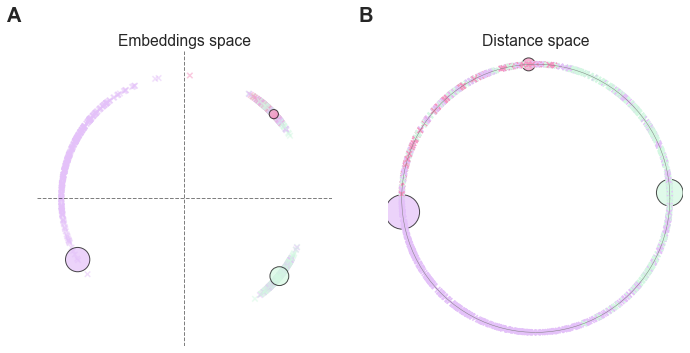

In [11]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    CIRCLE_RADIUS,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [12]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "toy_dataset.png"), dpi=300)

In [13]:
# save_dataset(toy, "../data/toy.pkl")

In [14]:
toy.items_capacities

array([[355, 591,  84]])

## 2. Model training

### 2.2 Test input data

In [15]:
assert toy.users_tensor.shape == torch.Size([n_users,])
assert toy.items_tensor.shape == torch.Size([n_users, n_items])
assert toy.D_tensor.shape == torch.Size([n_users, n_items])
assert toy.y_true_tensor.shape == torch.Size([n_users])

assert isinstance(toy.users_tensor, torch.LongTensor)
assert isinstance(toy.items_tensor, torch.LongTensor)
assert isinstance(toy.D_tensor, torch.FloatTensor)
assert isinstance(toy.y_true_tensor, torch.LongTensor)

### 2.3 Train the model

Uncomment next line to reload the model if changing the source code in `src.ml.model.ModelOT`

In [16]:
# %autoreload 2

In [32]:
#################
# Declare model #
#################

model = ModelOT(
    capacities=toy.items_capacities,
    n_users=toy.n_users,
    epsilon=0.05,
    alpha=0.5,
    n_iter=20,
    n_features=n_features,
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)
model.train()

optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.NLLLoss()

n_epochs = 400

#########
# Train #
#########

losses = []
scores = []

for epoch in range(n_epochs):
    train_epoch_loss = 0
    optimizer.zero_grad()

    # model out
    r_ij = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)
    e_usage = r_ij.sum(axis=0)

    # predictions
    # y_pred = torch.argmax(r_ij, axis=1)
    # y_pred = torch.distributions.Categorical(torch.exp(r_ij)).sample()
    y_pred = assign_with_lap(r_ij, toy.items_capacities)

    # loss function
    loss = criterion(torch.log(r_ij), toy.y_true_tensor)
    train_epoch_loss += loss.item()
    loss.backward()

    # optimizer
    optimizer.step()

    # training loss
    losses.append([loss.item()])

    # training scores
    acc = accuracy_score(y_true=toy.y_true_tensor, y_pred=y_pred)
    f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")
    
    embedding_distance = np.linalg.norm(
        model.item_embeddings.weight.data.numpy() - toy.items_features, axis=1
    )
    
    scores.append([acc, f1, np.mean(embedding_distance)])
    
########################
# Store training stats #
########################

losses_df = pd.DataFrame(
    dict(
        epoch=["{0}".format(i) for i in np.arange(1, len(losses)+1)],
        loss=[l[0] for l in losses]
    )
)

scores_df = pd.DataFrame(
    dict(
        epoch=["{0}".format(i) for i in np.arange(1, len(losses)+1)],
        acc=[s[0] for s in scores],
        f1=[s[1] for s in scores],
        distances=[s[2] for s in scores]
    )
)

capacities_df = pd.DataFrame(
    dict(
        center_id=["Item {0}".format(i)
                   for i in np.arange(1, toy.items_capacities.shape[1]+1)],
        capacities=toy.items_capacities.reshape(-1),
        expected_usage=e_usage.data.numpy(),
        actual_usage=torch.nn.functional.one_hot(
            y_pred,
            num_classes=toy.items_capacities.shape[1]
        ).sum(axis=0).data.numpy()
    )
)

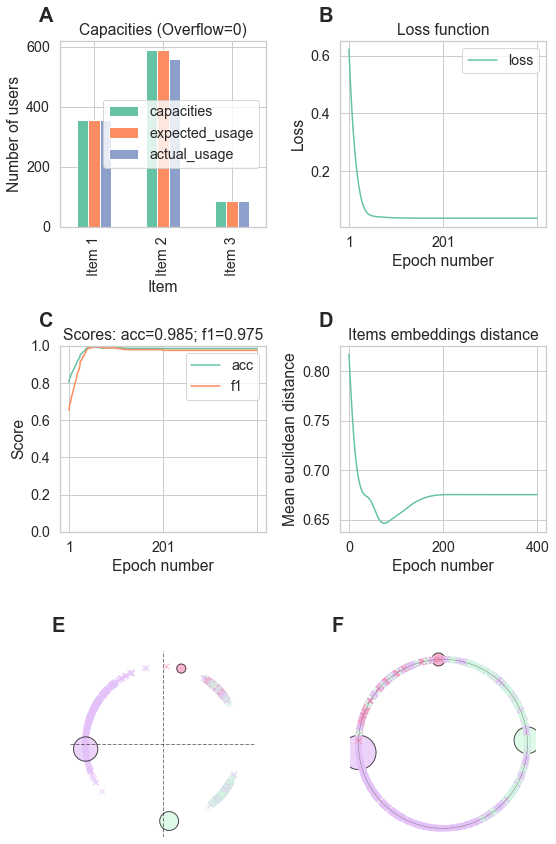

In [33]:
#######################
# Plot training stats #
#######################

fig, axs = plt.subplots(figsize=(8, 12), nrows=3, ncols=2)

# Capacities barplot
viz.plot_capacities(
    capacities_df,
    axs[0][0]
)

axs[0][0].legend(loc="center right")

# Loss function per epoch
viz.plot_losses(
    losses_df,
    axs[0][1]
)

# Accuracy and F1 scores per epoch
viz.plot_scores(
    scores_df.drop("distances", axis=1),
    axs[1][0]
)

# Confusion matrix as heatmap
# viz.plot_heatmap(
#    y_true,
#    y_pred,
#    toy.items_capacities.shape[1],
#    axs[1][1]
#)

# Embeddings distance
scores_df["distances"].plot(kind="line", ax=axs[1][1])
axs[1][1].set_xlabel("Epoch number")
axs[1][1].set_ylabel("Mean euclidean distance")
axs[1][1].set_title("Items embeddings distance")

# Learned items embeddings and assigned users
viz.plot_embeddings(
    users_features=model.user_embeddings.weight,
    items_features=model.item_embeddings.weight,
    items_capacities=toy.items_capacities,
    y_pred=y_pred,
    ax=axs[2][0]
)

# Distance circle and assigned users
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    CIRCLE_RADIUS,
    y_pred,
    toy.items_capacities,
    axs[2][1]
)

# Annotate with letters
for i in range(6):
    axs[i//2][i%2].text(-0.1, 1.1, string.ascii_uppercase[i],
                   transform=axs[i//2][i%2].transAxes, 
                   size=20, weight="bold")

plt.tight_layout()
plt.show()

In [35]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "training_results.png"), dpi=300)

## 3. Minibatch training

In [36]:
%%time

large_dataset = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=10000,
    n_features=n_features,
    distance_weight=distance_weight
)

CPU times: user 1min 52s, sys: 1.7 s, total: 1min 54s
Wall time: 1min 55s


In [37]:
batch_experiments = []

for assign in ["lap", "argmax"]:
    for batch_size_ratio in [0.01, 0.05, 0.1, 0.2, 0.3]:
        batch_size = int(batch_size_ratio*large_dataset.n_users)

        data_loader = torch.utils.data.DataLoader(
            large_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        large_model = ModelOT(
            capacities=large_dataset.items_capacities,
            n_users=large_dataset.n_users,
            epsilon=0.05,
            alpha=0.5,
            n_iter=20,
            n_features=2,
            user_embeddings=torch.FloatTensor(large_dataset.users_features),
            train_user_embeddings=False
        )

        large_model.train()

        optimizer = torch.optim.Adam(lr=0.01, params=large_model.parameters())
        criterion = torch.nn.NLLLoss()

        losses = []
        scores = []

        #########
        # Train #
        #########

        start = time.time()
        for _ in range(100):
            train_epoch_loss = 0
            y_pred = []

            optimizer.zero_grad()

            for i, (users_tensor_tmp, items_tensor_tmp, D_tensor_tmp, y_true_tmp) in enumerate(data_loader):
                scaling_factor = users_tensor_tmp.shape[0] / large_dataset.n_users

                r_ij = large_model(users_tensor_tmp, items_tensor_tmp, D_tensor_tmp)
                e_usage = r_ij.sum(axis=0)

                scaled_capacities = np.round(large_dataset.items_capacities * scaling_factor)

                if assign == "lap":
                    y_pred_batch = assign_with_lap(r_ij, scaled_capacities)
                elif assign == "argmax":
                    y_pred_batch = torch.argmax(r_ij, axis=1)

                y_pred += y_pred_batch

                # loss function
                loss = criterion(torch.log(r_ij), y_true_tmp)
                train_epoch_loss += loss.item()
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            train_epoch_loss = train_epoch_loss / (i+1)

        y_pred = [t.item() for t in y_pred]

        # Training time
        elapsed_time = time.time() - start

        # F1 Score
        f1 = f1_score(y_true=large_dataset.y_true_tensor, y_pred=y_pred, average="macro")

        # Overflow
        actual_usage=torch.nn.functional.one_hot(torch.LongTensor(y_pred),
                                                 num_classes=large_dataset.items_capacities.shape[1]
                                                ).sum(axis=0).data.numpy()
        delta = actual_usage - large_dataset.items_capacities
        overflow = np.where(delta <= 0, 0, delta).sum()

        batch_experiments.append(
            dict(
                assign=assign,
                batch_size=batch_size,
                batch_size_ratio=batch_size_ratio,
                f1=f1,
                overflow=overflow,
                training_time=elapsed_time
            )
        )

KeyboardInterrupt: 

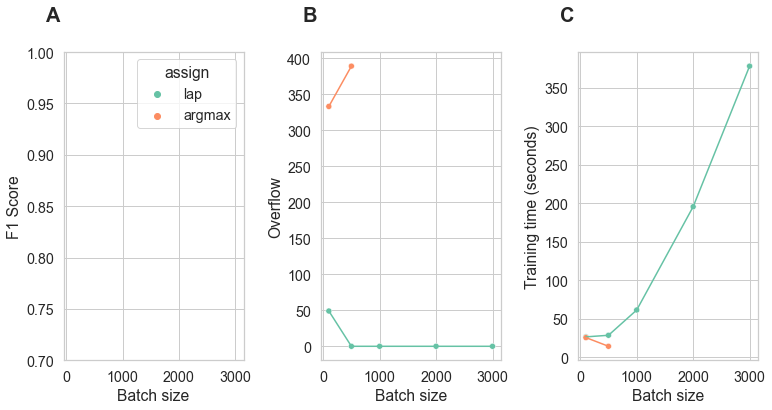

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 6), sharex=True)

# F1 score
sns.scatterplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="f1",
    hue="assign",
    ax=axs[0]
)
sns.lineplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="f1",
    hue="assign",
    ax=axs[0],
    legend=False
)

axs[0].set_ylim(.7, 1)
axs[0].set_xlabel("Batch size")
axs[0].set_ylabel("F1 Score")

# F1 score
sns.scatterplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="overflow",
    hue="assign",
    ax=axs[1],
    legend=False
)
sns.lineplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="overflow",
    hue="assign",
    ax=axs[1],
    legend=False
)

axs[1].set_xlabel("Batch size")
axs[1].set_ylabel("Overflow")

# Training time
sns.scatterplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="training_time",
    hue="assign",
    ax=axs[2],
    legend=False
)
sns.lineplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="training_time",
    hue="assign",
    ax=axs[2],
    legend=False
)

axs[2].set_xlabel("Batch size")
axs[2].set_ylabel("Training time (seconds)")


# Annotate with letters
for i in range(3):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "batch_size.png"), dpi=300)

## 4. Experiments

### 4.1 Model parameters

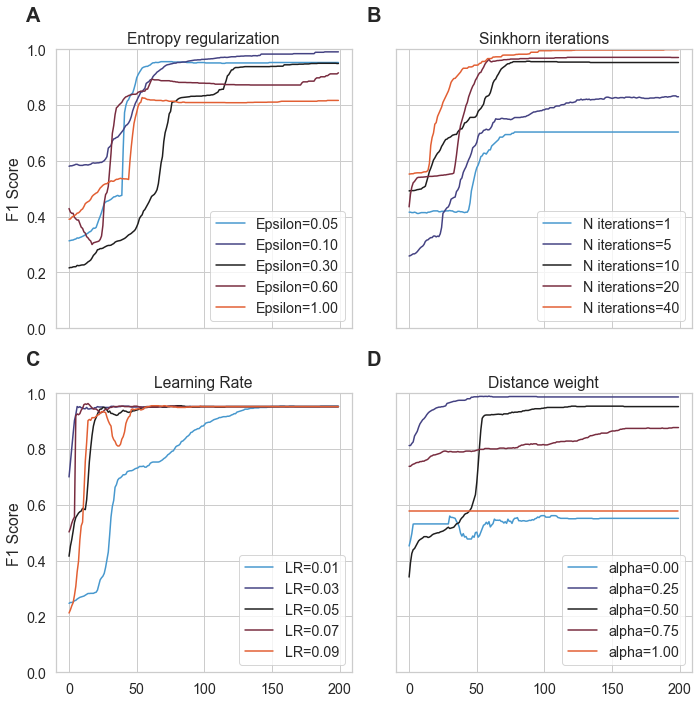

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        figsize=(10, 10), 
                        sharex=True, sharey=True)

axs[0][0].set_ylim(0, 1)
axs[0][0].set_xlabel("Epoch")
axs[0][0].set_ylabel("F1 Score")
axs[1][0].set_ylabel("F1 Score")

pal = "icefire"

###########
# Epsilon #
###########

for i, epsilon in enumerate([0.05, 0.1, 0.3, 0.6, 1]):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        toy.y_true_tensor, 
        toy.items_capacities, 
        toy.items_features,
        n_features=2,
        lr=0.01, 
        epsilon=epsilon, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False,
        assign="lap"
    )
    
    scores_df_tmp["f1"].rename("Epsilon={0:.2f}".format(epsilon)).plot(
        ax=axs[0][0],
        color=sns.color_palette(pal, n_colors=5)[i]
    )
    axs[0][0].legend(loc="lower right")
    axs[0][0].set_title("Entropy regularization")
    
#######################
# Sinkhorn iterations #
#######################

for i, n_iter in enumerate([1, 5, 10, 20, 40]):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        toy.y_true_tensor,
        toy.items_capacities, 
        toy.items_features,
        n_features=2,
        lr=0.01, 
        epsilon=0.05, 
        n_iter=n_iter,
        alpha=0.5, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False,
        assign="lap"
    )
    
    scores_df_tmp["f1"].rename("N iterations={0}".format(n_iter)).plot(
        ax=axs[0][1],
        color=sns.color_palette(pal, n_colors=5)[i]
    )
    axs[0][1].legend(loc="lower right")
    axs[0][1].set_title("Sinkhorn iterations")
    
#################
# Learning rate #
#################

for i, lr in enumerate(np.arange(0.01, 0.1, 0.02)):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        toy.y_true_tensor,
        toy.items_capacities, 
        toy.items_features,
        n_features=2,
        lr=lr, 
        epsilon=0.05, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False,
        assign="lap"
    )
    
    scores_df_tmp["f1"].rename("LR={0:.2f}".format(lr)).plot(
        ax=axs[1][0],
        color=sns.color_palette(pal, n_colors=5)[i]
    )
    axs[1][0].legend(loc="lower right")
    axs[1][0].set_title("Learning Rate")
    
#########
# Alpha #
#########

for i, alpha in enumerate(np.arange(0.0, 1.25, 0.25)):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        toy.y_true_tensor,
        toy.items_capacities, 
        toy.items_features,
        n_features=2,
        lr=0.01, 
        epsilon=0.05, 
        n_iter=10,
        alpha=alpha, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False,
        assign="lap"
    )
    
    scores_df_tmp["f1"].rename("alpha={0:.2f}".format(alpha)).plot(
        ax=axs[1][1],
        color=sns.color_palette(pal, n_colors=5)[i]
    )
    axs[1][1].legend(loc="lower right")
    axs[1][1].set_title("Distance weight")
    
# Annotate with letters
for i in range(4):
    axs[i//2][i%2].text(-0.1, 1.1, string.ascii_uppercase[i],
                   transform=axs[i//2][i%2].transAxes, 
                   size=20, weight="bold")
    
plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_params.png"), dpi=300)

### 4.2 Repeatability

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

scores = []

for _ in range(40):
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        toy.y_true_tensor,
        toy.items_capacities, 
        toy.items_features,
        n_features=n_features,
        lr=0.01, 
        epsilon=0.05, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,users_features=toy.users_features,
        train_user_embeddings=False,
        assign="lap"
    )
    
    scores.append(scores_df_tmp["f1"].iloc[-1])
    
    # Plot 1: lines with F1 per epoch
    scores_df_tmp["f1"].plot(ax=axs[0], 
                             alpha=.1, 
                             color=sns.color_palette()[0])
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("F1 score")
    
# Plot 2: F1 scores distribution
sns.kdeplot(scores,
            ax=axs[1],
            fill=True)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel("F1 score")
axs[1].set_ylabel("Density")

plt.show()

In [55]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_repeatability.png"), dpi=300)

### 4.3 Test epsilon influence on F1 and overflow

In [ ]:
f1_tmp = []

for epsilon in [0.03, 0.05, 0.08, 0.1, 0.3 ,0.5, 0.8, 1]:
    for assign in ["lap", "argmax"]:
        y_pred_tmp, _, _, scores_df_tmp, capacities_df_tmp = train_model(
            toy.users_tensor, 
            toy.items_tensor, 
            toy.D_tensor, 
            toy.y_true_tensor,
            toy.items_capacities, 
            toy.items_features,
            n_features=2,
            lr=0.01,
            epsilon=epsilon, 
            n_iter=10,
            alpha=0.5, 
            n_epochs=200,
            users_features=toy.users_features,
            train_user_embeddings=False,
            assign=assign
        )
        
        delta = (capacities_df_tmp["actual_usage"] - capacities_df_tmp["capacities"]).values
        overflow = np.where(delta < 0, 0, delta).sum()

        f1_tmp.append(
            dict(
                epsilon=epsilon,
                assign=assign,
                f1=scores_df_tmp["f1"].iloc[-1],
                overflow=overflow
            )
        )

In [ ]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 5),
    sharex=True
)

############
# F1 score #
############
sns.scatterplot(
    data=pd.DataFrame(f1_tmp),
    x="epsilon",
    y="f1",
    hue="assign",
    ax=axs[0]
)

sns.lineplot(
    data=pd.DataFrame(f1_tmp),
    x="epsilon",
    y="f1",
    hue="assign",
    ax=axs[0],
    legend=False
)

axs[0].set_ylim(.7, 1)
axs[0].legend(title="Assignment")

############
# Overflow #
############
sns.scatterplot(
    data=pd.DataFrame(f1_tmp),
    x="epsilon",
    y="overflow",
    hue="assign",
    ax=axs[1],
    legend=False
)

sns.lineplot(
    data=pd.DataFrame(f1_tmp),
    x="epsilon",
    y="overflow",
    hue="assign",
    ax=axs[1],
    legend=False
)

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")
    
axs[0].set_xlabel("Epsilon")
axs[1].set_xlabel("Epsilon")
axs[0].set_ylabel("F1 Score")
axs[1].set_ylabel("Overflow")

plt.tight_layout()
plt.show()

In [96]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_epsilon.png"), dpi=300)

### 4.4 Noise influence

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

noise_results = []

################
# Permutations #
################
toy_tmp = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    distance_weight=.5,
    n_features=2
)

for i, noise in enumerate([0, 0.025, 0.05, 0.1, 0.2, 0.5, 1]):
    # apply noise to y_true without drawing a new dataset
    y_true_tmp_noised = torch.from_numpy(
        toy_tmp.add_random_permutations(int(noise*toy_tmp.n_users))
    )
    
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        toy_tmp.users_tensor, 
        toy_tmp.items_tensor, 
        toy_tmp.D_tensor, 
        y_true_tmp_noised,
        toy_tmp.items_capacities, 
        toy_tmp.items_features,
        n_features=2,
        lr=0.01, 
        epsilon=0.05, 
        n_iter=10,
        alpha=0.5, 
        n_epochs=200,
        users_features=toy_tmp.users_features,
        train_user_embeddings=False
    )
    
    scores_df_tmp["f1"].rename("Noise={0}".format(noise)).plot(
        ax=axs[0],
        color=sns.color_palette("icefire", n_colors=7)[i]
    )
    
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("F1 score")
    axs[0].legend(loc="lower right", ncol=2)
    axs[0].set_title("Permutation noise")
    
    noise_results.append(
        dict(
            kind="permutation",
            noise=noise,
            f1=scores_df_tmp["f1"].iloc[-1],
            distances=scores_df_tmp["distances"].iloc[-1]
        )
    )

##################
# Gaussian noise #
##################
for i, ratio in enumerate(np.arange(0, 1.2, 0.2)):
    toy_tmp = ToyDataset(
        n_centers=n_centers,
        n_items=n_items,
        n_users=n_users,
        distance_weight=.5,
        n_features=2
    )
    toy_tmp.users_features = toy_tmp.add_gaussian_noise_to_users_features(ratio=ratio)

    y_pred_tmp, model_tmp, _, scores_df_tmp, capacities_df_tmp = train_model(
        toy_tmp.users_tensor, 
        toy_tmp.items_tensor, 
        toy_tmp.D_tensor, 
        toy_tmp.y_true_tensor,
        toy_tmp.items_capacities, 
        toy_tmp.items_features,
        n_features=2,
        lr=0.01, 
        epsilon=0.1, 
        n_iter=10,
        alpha=.5, 
        n_epochs=200,
        users_features=toy_tmp.users_features,
        train_user_embeddings=False
    )
    
    scores_df_tmp["f1"].rename("Noise={0:.1f}".format(ratio)).plot(
        ax=axs[1],
        color=sns.color_palette("icefire", n_colors=7)[i]
    )
    
    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("F1 score")
    axs[1].legend(loc="lower right", ncol=2)
    axs[1].set_title("Gaussian noise")
    
    noise_results.append(
        dict(
            kind="gaussian",
            noise=ratio,
            f1=scores_df_tmp["f1"].iloc[-1],
            distances=scores_df_tmp["distances"].iloc[-1]
        )
    )

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))

############
# F1 score #
############

sns.scatterplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="f1",
    hue="kind",
    ax=axs[0]
)
sns.lineplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="f1",
    hue="kind",
    ax=axs[0],
    legend=False
)

axs[0].legend(loc="lower left")
axs[0].set_xlabel("Noise")
axs[0].set_ylabel("F1 Score")

############
# Distance #
############

sns.scatterplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="distances",
    hue="kind",
    ax=axs[1],
    legend=False
)
sns.lineplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="distances",
    hue="kind",
    ax=axs[1],
    legend=False
)

axs[1].set_xlabel("Noise")
axs[1].set_ylabel("Distance")


# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [107]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_noise.png"), dpi=300)

### 4.5 Latent space dimension

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6), sharex=True)

######################
# Number of features #
######################
for i, n_features_tmp in enumerate([2, 8, 32, 128, 256]):
    toy_tmp = ToyDataset(
        n_centers=n_centers,
        n_items=n_items,
        n_users=n_users,
        distance_weight=.5,
        n_features=n_features_tmp
    )
    
    y_pred_tmp, _, _, scores_df_tmp, capacities_df_tmp = train_model(
        toy_tmp.users_tensor, 
        toy_tmp.items_tensor, 
        toy_tmp.D_tensor, 
        toy_tmp.y_true_tensor,
        toy_tmp.items_capacities, 
        toy_tmp.items_features,
        n_features=n_features_tmp,
        lr=0.01, 
        epsilon=0.1, 
        n_iter=10,
        alpha=.5, 
        n_epochs=200,
        users_features=toy_tmp.users_features,
        train_user_embeddings=False
    )
    
    ############
    # F1 Score #
    ############
    scores_df_tmp["f1"].rename("Features={0:.0f}".format(n_features_tmp)).plot(
        kind="line",
        color=sns.color_palette("icefire", n_colors=5)[i],
        ax=axs[0]
    )
    
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("F1 score")
    axs[0].legend(loc="lower right", ncol=2)
    axs[0].set_title("Number of features")
    
    #######################
    # Embeddings distance #
    #######################
    scores_df_tmp["distances"].plot(
        kind="line",
        color=sns.color_palette("icefire", n_colors=5)[i],
        ax=axs[1]
    )
    axs[1].set_xlabel("Epoch number")
    axs[1].set_ylabel("Mean euclidean distance")
    axs[1].set_title("Items embeddings distance")
    
# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")
    
plt.tight_layout()
plt.show()

In [160]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_dimension.png"), dpi=300)

## 5. Training time 

In [ ]:
training_time = []

for assign in ["lap", "argmax"]:
    for i, n_users_tmp in enumerate([10, 100, 500, 1000, 1500]):
        toy_tmp = ToyDataset(
            n_centers=n_centers,
            n_items=n_items,
            n_users=n_users_tmp,
            distance_weight=.5,
            n_features=2
        )

        start = time.time()

        y_pred_tmp, _, _, scores_df_tmp, capacities_df_tmp = train_model(
            toy_tmp.users_tensor, 
            toy_tmp.items_tensor, 
            toy_tmp.D_tensor, 
            toy_tmp.y_true_tensor,
            toy_tmp.items_capacities, 
            toy_tmp.items_features,
            n_features=2,
            lr=0.01, 
            epsilon=0.1, 
            n_iter=10,
            alpha=.5, 
            n_epochs=200,
            users_features=toy_tmp.users_features,
            train_user_embeddings=False
        )

        elapsed = time.time() - start
        
        training_time.append(
            dict(
                n_users=n_users_tmp,
                assign=assign,
                elapsed_time=elapsed
            )
        )

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(
    data=pd.DataFrame(training_time),
    x="n_users",
    y="elapsed_time",
    hue="assign",
    ax=ax
)
sns.lineplot(
    data=pd.DataFrame(training_time),
    x="n_users",
    y="elapsed_time",
    hue="assign",
    ax=ax,
    legend=False
)

ax.legend(title="Assignment")
ax.set_xlabel("Number of users")
ax.set_ylabel("Training time (seconds)")
# ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "training_time.png"), dpi=300)